# Part 3: Decoding with deep learning


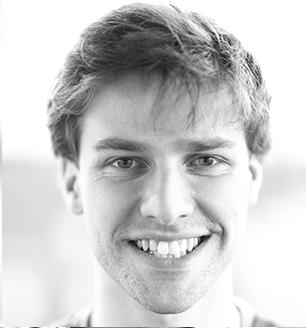

In [9]:
# @title Intro
from IPython.display import display, HTML
from base64 import b64encode

# Main profile image path
main_path = "images/profile_banville.jpg"

# Two small logos paths
logo1_path = "images/Meta_lockup_positive primary_RGB.png" # Replace with actual paths

# Encode images in base64
def encode_img(path):
    with open(path, "rb") as f:
        return b64encode(f.read()).decode("utf-8")

main_img = encode_img(main_path)
logo1_img = encode_img(logo1_path)

html = f"""
<div style="display: flex; align-items: flex-start; justify-content: space-between;">
    <!-- Left side: profile image and text -->
    <div style="display: flex; align-items: flex-start;">
        <img src="data:image/png;base64,{main_img}" width="200" style="margin-right: 20px;"/>
        <div style="font-size: 24px; font-weight: bold; margin-bottom: 8px;">
            <b>Part 3: Decoding with deep learning</b><br>
            <div style="font-size: 18px; line-height: 1.5; font-weight: normal;">
                Hubert Banville, PhD<br>
                Research Scientist at Meta FAIR.<br><br>
                Relevant <a href="https://arxiv.org/abs/2501.15322" target="_blank">paper</a>: <br>
                "Scaling laws for decoding images from brain activity"<br><br>
                Keep in touch:
                    <a href="https://hubertjb.github.io/" target="_blank">Website</a>
            </div>
        </div>
    </div>

    <!-- Right side: two small logos -->
    <div style="display: flex; flex-direction: column; gap: 10px; margin-left: 20px;">
    <div style="display: flex; flex-direction: column; gap: 10px; margin-left: 20px; align-items: center;">

        <img src="data:image/png;base64,{logo1_img}" width="200" style="object-fit: contain;" />
    </div>
</div>
"""

display(HTML(html))

In this third part, we will build upon previous sections to construct a flexible deep learning pipeline to decode word embeddings from MEG data.

**Contents**:

0. Why decoding with deep learning?
1. Preparing dataloaders
2. Building the model
3. Preparing the training loop
4. Training the model
5. Visualizing the results
6. Leveraging exca for large-scale experimentation and next steps

[Insert visual summary]

*This notebook is inspired by this tutorial on [deep learning for sleep staging from EEG](https://github.com/hubertjb/dl-eeg-tutorial).*

⚠️ **Before starting, make sure you're on a GPU instance for faster training!** ⚠️

> If running on Google Colab, please request a GPU runtime by clicking `Runtime/Change runtime type` in the top bar menu, then selecting 'T4 GPU' under 'Hardware accelerator'.

In [10]:
# Identify whether a CUDA-enabled GPU is available
from pathlib import Path
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg ='CUDA-enabled GPU found. Training should be faster.'
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting \'T4 GPU\'\nunder \'Hardware accelerator\'."
    )
print(msg)

CUDA-enabled GPU found. Training should be faster.


In [2]:
#@title ▶️ Let's download the data in case it's not yet available

if not Path("data").exists():
  !gdown 1jkadTwM2FbAojuwjRw_KdMpDoni7l4Xz -O data.zip
  !unzip -q data.zip -d data

!ls data/

Downloading...
From (original): https://drive.google.com/uc?id=1jkadTwM2FbAojuwjRw_KdMpDoni7l4Xz
From (redirected): https://drive.google.com/uc?id=1jkadTwM2FbAojuwjRw_KdMpDoni7l4Xz&confirm=t&uuid=a8d3e337-6377-40c6-bee8-1a5ff05bd0cc
To: /content/data.zip
100% 1.41G/1.41G [00:16<00:00, 83.4MB/s]
events.csv
LibriBrain2025_subject-0_session-1_run-1_task-Sherlock1_preproc.fif
LibriBrain2025_subject-0_session-1_run-1_task-Sherlock2_preproc.fif
LibriBrain2025_subject-0_session-1_run-1_task-Sherlock3_preproc.fif
LibriBrain2025_subject-0_session-1_run-1_task-Sherlock4_preproc.fif
LibriBrain2025_subject-0_session-1_run-1_task-Sherlock5_preproc.fif
LibriBrain2025_subject-0_session-1_run-1_task-Sherlock6_preproc.fif
LibriBrain2025_subject-0_session-1_run-1_task-Sherlock7_preproc.fif


In [3]:
#@title ▶️ Install additional required packages for colab
!pip install lightning==2.5.2 --no-deps  # to avoid installing another torch version than default one on colab
!pip install pytorch-lightning --no-deps
!pip install torchmetrics --no-deps
!pip install lightning-utilities
!pip install torchinfo
!pip install exca
!pip install mne
!pip install spacy
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00


## 0. Why should we look beyond linear models?

Linear models are fast to train, easy to interpret, and yield good performance. Why should we look into more complicated deep learning models?

Some reasons include:

1. Enables learning powerful **non-linear features end-to-end** -> often yields better decoding performance
2. Facilitate **cross-subject learning** by using subject-specific layers or embeddings
3. Allows using **custom learning objectives** such as contrastive losses (e.g. CLIP) to align predictions and modality (word) embeddings

Successful applications of deep models to M/EEG decoding tasks from our team include:
* 💬 [Speech decoding (Défossez et al., 2023)](https://www.nature.com/articles/s42256-023-00714-5)
* 🖼️ [Image decoding (Benchetrit et al., 2023)](https://arxiv.org/abs/2310.19812)
* 📄 [Word decoding (d'Ascoli et al., 2024)](https://arxiv.org/abs/2412.17829)
* ⌨️ [Typing decoding (Lévy et al., 2025)](https://arxiv.org/abs/2502.17480)

[Add image from one of the papers]

### In this notebook

Below, we will build everything we need to train a deep learning model on the word embedding decoding task, including:

- Preparing the dataloaders
- Building the deep learning model
- Preparing the training loop
- Training the model
- Visualizing the results

In [11]:
# Set some paths to locate the data and cache/save results
DATA_DIR = Path("data")
CACHE_DIR = Path("cache")
RESULTS_DIR = Path("results")

assert DATA_DIR.exists()
CACHE_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
#@title ▶️ Run this to redefine utilities from parts 1 and 2

import typing as tp

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pydantic
import spacy
from exca import MapInfra, TaskInfra
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, RobustScaler
from wordfreq import zipf_frequency


class Neuro(pydantic.BaseModel):

    model_config = pydantic.ConfigDict(extra="forbid")

    preproc_path: Path
    fmin: float = 0.1
    fmax: float = 40.
    freq: float = 80.

    apply_robust_scaler: bool = True  # whether to apply robust scaling to the neural data
    tmin: float = -.5
    tmax: float = 1.

    def prepare_neuro(self, session: str) -> mne.io.Raw:

        """ Load the raw neuro data and filter """

        file = Path(self.preproc_path) / f"{session}_preproc.fif"

        if file.exists():
            raw = mne.io.read_raw(file, verbose="ERROR")

        else:
            fmin = self.fmin
            fmax = self.fmax
            freq = self.freq

            original_file = self.preproc_path / f"{session}.fif" # original file
            raw = mne.io.read_raw(original_file)
            raw = raw.pick(picks=["meg"]) # don't want to analyse misc

            # band pass filter
            raw = raw.filter(fmin, fmax)

            # downsample
            if freq != raw.info["sfreq"]:
                raw = raw.resample(freq)

        return raw

    def __call__(self, session: str) -> tuple[np.ndarray, list[str]]:
        """ Segment the neural data around words """

        raw = self.prepare_neuro(session)

        if self.apply_robust_scaler:
            raw.load_data()
            raw._data = RobustScaler().fit_transform(raw._data.T).T

        events = pd.read_csv(self.preproc_path / "events.csv")

        # Select the words in the relevant session
        words = events[(events['type'] == 'Word') & (events['session'] == session)].dropna().reset_index(drop=True)

        # Get word onsets in samples
        word_onsets = np.ones((len(words), 3), dtype=int) # mne.epochs expects events of shape (n_events, 3) but we are only interested in the first column here -> set the rest to 0
        word_onsets[:, 0] = words.start *raw.info["sfreq"] # first column must contain the onset of each event (word) in samples

        # Segment
        segments = mne.Epochs(
            raw,
            word_onsets,
            metadata=words,
            event_repeated="drop",
            baseline=(self.tmin, 0),  # setting a baseline (-0.2, 0) can improve decoding results. Baselining subtracts the mean value over this window from the entire segment.
            tmin=self.tmin,
            tmax=self.tmax,
            verbose="ERROR"
        )
        del raw

        # from mne to numpy
        words = segments.metadata['text']
        neuro_array = segments.get_data(verbose="ERROR").astype(np.float32)
        del segments

        # clip segments to prevent outliers impacting regression
        neuro_array = np.clip(neuro_array, a_min=-20, a_max=20)

        n_words, n_channels, n_times = neuro_array.shape

        return neuro_array, words


class Feature(pydantic.BaseModel):
    model_config = pydantic.ConfigDict(extra="forbid")

    feature: tp.Literal['zipf_frequency', 'word_embedding']
    _model = None

    infra: MapInfra = MapInfra(version="v1")

    def model_post_init(self, __context):
        if self.feature == "word_embedding":
            try:
                spacy.load("en_core_web_lg")  # Ensure the spaCy model is loaded
            except OSError:
                spacy.cli.download("en_core_web_lg")  # Ensure the spaCy model is downloaded

    @infra.apply(item_uid=lambda x: str(x))
    def embed(self, words: list[str]) -> tp.Iterator[np.array]:
        if self._model is None:
            self._model = spacy.load("en_core_web_lg")
        for word in words:
            yield self._model(word).vector.astype(np.float32)


class Data(pydantic.BaseModel):
    model_config = pydantic.ConfigDict(extra="forbid")

    neuro: Neuro
    feature: Feature
    n_sessions: int = 1

    def __call__(self) -> tuple[np.ndarray, np.ndarray]:

        """ concatenate neural data and feature over multiple sessions """

        # get data
        neuro_array = []
        words = []

        print("Preparing neuro")
        sessions = [i.name.split("_preproc")[0] for i in sorted(list(self.neuro.preproc_path.glob("*.fif")))] # neuro files available in path
        if self.n_sessions > len(sessions):
            raise ValueError(f"You requested {self.n_sessions} but there are only {len(sessions)} available.")

        for session in sessions[:self.n_sessions]:
            session_neuro_array, session_words = self.neuro(session)
            neuro_array.append(session_neuro_array)
            words.extend(session_words)
        neuro_array = np.concatenate(neuro_array, 0)

        # compute embedding
        print("Preparing feature")
        feature_array = np.vstack(list(self.feature.embed(words)))  # (n_words, n_dims)

        return neuro_array, feature_array


/private/home/hubertjb/miniconda3/envs/brainai_v2/lib/python3.12/site-packages/cupy/_environment.py:370: UserWarning: CuPy failed to preload library (/private/home/hubertjb/.cupy/cuda_lib/11.x/cutensor/2.1.0/lib/libcutensor.so.2.1.0): OSError (libcublasLt.so.11: cannot open shared object file: No such file or directory)
  warnings.warn(msg)


## 1. Building the dataloaders

We start by loading the preprocessed MEG windows and word embeddings from the LibriBrain dataset, using the `Data` class defined in part 1.

NOTE: For the purpose of this tutorial, we only make available (and load) a part of the entire LibriBrain dataset (3 sessions out of 92). Loading more recordings will likely improve results, though will take more time at the data preparation and model training steps.

In [13]:
data_config = {
    "neuro": {
        "preproc_path": DATA_DIR,
        "tmin": -0.2,
        "tmax": 1.8 - 1/80,
        "apply_robust_scaler": True,
    },
    "feature": {
        "feature": "word_embedding",
        "infra": {
            "folder": CACHE_DIR,
        },
    },
    "n_sessions": 4,
}

In [ ]:
# Get neuro and word data (~75 s to run)
X, y = Data(**data_config)()

print(f"\nData shape\nX: {X.shape}\ny: {y.shape}")

Preparing neuro
Reading 0 ... 88959  =      0.000 ...  1111.987 secs...
Reading 0 ... 104159  =      0.000 ...  1301.987 secs...
Reading 0 ... 273599  =      0.000 ...  3419.988 secs...
Reading 0 ... 291839  =      0.000 ...  3647.988 secs...
Preparing feature


100%|██████████| 3846/3846 [00:25<00:00, 151.54it/s]


Data shape
X: (24210, 306, 160)
y: (24210, 300)


Now that we have our windowed data, we can split it into the different sets that are needed for modeling:
(1) the training set is used to learn the parameters of our deep learning model,
(2) the validation set is used to monitor the training process and decide when to stop it, and
(3) the test set is used to provide an estimate of the generalization performance of our model.

Here, we use the last 10% of windows for testing, and split the remaining 90% of windows into training and validation sets.

In [15]:
# Prepare dataloaders

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

valid_split_ratio = 0.1
test_split_ratio = 0.1
random_state = 42
batch_size = 128
num_workers = 2

# Split into train/valid/test
inds = np.arange(X.shape[0])
inds_train, inds_test = train_test_split(
    inds, shuffle=False, test_size=test_split_ratio,
)
inds_train, inds_valid  = train_test_split(
    inds_train,
    shuffle=True,
    test_size=valid_split_ratio / (1 - test_split_ratio),
    random_state=random_state,
)

X_train, X_valid, X_test = X[inds_train], X[inds_valid], X[inds_test]
y_train, y_valid, y_test = y[inds_train], y[inds_valid], y[inds_test]
del X, y

We standardize the word embeddings to have zero mean and unit variance, which is a common practice in machine learning to ensure that all features contribute equally to the model training and stabilize training.

In [16]:
# Normalize targets
target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train)
y_valid = target_scaler.transform(y_valid)
y_test = target_scaler.transform(y_test)

Finally, we create pytorch `DataLoader`s, which will be used to feed the data to the model during training and evaluation:

In [18]:
# Create datasets and dataloaders
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

valid_dataset = TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid))
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Number of examples in each split")
print(f"Train:\t{len(train_dataset)}")
print(f"Valid:\t{len(valid_dataset)}")
print(f"Test:\t{len(test_dataset)}")

Number of examples in each split
Train:	19368
Valid:	2421
Test:	2421


## 2. Building the deep learning model

In this section, we will define our deep learning architecture.

We will use the residual dilated convolutional neural network of [Défossez et al. (2023)](https://www.nature.com/articles/s42256-023-00714-5). It performed well on multiple other M/EEG decoding tasks, e.g. [image decoding ](https://arxiv.org/abs/2310.19812), [word decoding](https://arxiv.org/abs/2412.17829) and [typing decoding](https://arxiv.org/abs/2502.17480).

Following the formulation of part 1, we have:

$y_{pred} = f_{\Theta}(X) $ \
$R = corr(y, y_{pred})$

where:
- $X$ is the neuro segments, of shape `(n_examples, n_channels, n_times)`;
- $y$ is the word embeddings, of shape `(n_examples, n_dims)`;
- $\Theta$ are the parameters of our convolutional network, to be tuned during training.

![image.png](attachment:image.png)

The following implementation is a simplified version of the [original version](https://github.com/facebookresearch/brainmagick/blob/main/bm/models/simpleconv.py#L22), in which we drop less critical features and hardcode some hyperparameters to simplify this tutorial.

In [19]:
#@title ▶️ Run this first to define the model class

import torch
from torch import nn


class ConvSequence(nn.Module):
    """Sequence of residual, dilated convolutional layers with GLU activation.
    """
    def __init__(
        self,
        channels: list[int],
        kernel_size: int = 4,
        dilation_growth: int = 2,
        dilation_period: int = 5,
        glu: int = 2,
        glu_context: int = 1,
    ) -> None:
        super().__init__()

        if dilation_growth > 1:
            assert kernel_size % 2 != 0, "Supports only odd kernel with dilation for now"

        self.sequence = nn.ModuleList()
        self.glus = nn.ModuleList()

        dilation = 1
        for k, (chin, chout) in enumerate(zip(channels[:-1], channels[1:])):
            layers: list[nn.Module] = []

            # conv layer
            if dilation_period and (k % dilation_period) == 0:
                dilation = 1

            layers.extend([
                nn.Conv1d(
                    chin,
                    chout,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=kernel_size // 2 * dilation,
                    dilation=dilation,
                    groups=1,
                ),
                nn.BatchNorm1d(num_features=chout),
                nn.GELU(),
            ])
            dilation *= dilation_growth

            self.sequence.append(nn.Sequential(*layers))
            if (k + 1) % glu == 0:
                self.glus.append(
                    nn.Sequential(
                        nn.Conv1d(chout, 2 * chout, 1 + 2 * glu_context, padding=glu_context),
                        nn.GLU(dim=1),
                    )
                )
            else:
                self.glus.append(None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for ind, module in enumerate(self.sequence):
            x = x + module(x)
            if self.glus[ind] is not None:
                x = self.glus[ind](x)
        return x


class SimpleConv(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden: int = 320,
        depth: int = 4,
        kernel_size: int = 3,
        growth: float = 1.0,
    ):
        super().__init__()

        assert kernel_size % 2 == 1, "For padding to work, this must be verified"
        self.input_linear = nn.Conv1d(in_channels, hidden, 1)

        # Build sequence of convolutional layers
        sizes = [hidden] + [
            int(round(hidden * growth**k)) for k in range(depth)
        ]
        self.encoder = ConvSequence(
            sizes, kernel_size=kernel_size,
        )

        # Temporal aggregation
        self.time_aggregation = nn.LazyLinear(1)
        self.output_linear = nn.Linear(hidden, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # B, C, T = x.shape
        x = self.input_linear(x)
        x = self.encoder(x)
        x = self.time_aggregation(x).squeeze(-1)  # (B, F, 1) -> (B, F)
        x = self.output_linear(x)
        return x


In [60]:
# Initialize the model
pl.seed_everything(42)
model = SimpleConv(
    in_channels=X_train.shape[1],
    out_channels=y_train.shape[1],
    hidden=320,  # Number of hidden dimensions
    depth=4,  # Number of convolutional layers
)

Seed set to 42


Let's print a summary of the model to see its architecture and number of parameters $\Theta$:

In [61]:
# Print model summary
from torchinfo import summary

batch = next(iter(train_dataloader))
input_data = {"x": batch[0][[0]]}
summary(model, input_data=input_data)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleConv                               [1, 300]                  --
├─Conv1d: 1-1                            [1, 320, 160]             98,240
├─ConvSequence: 1-2                      [1, 320, 160]             --
│    └─ModuleList: 2-3                   --                        (recursive)
│    │    └─Sequential: 3-1              [1, 320, 160]             308,160
│    │    └─Sequential: 3-2              [1, 320, 160]             308,160
│    └─ModuleList: 2-4                   --                        (recursive)
│    │    └─Sequential: 3-3              [1, 320, 160]             615,040
│    └─ModuleList: 2-3                   --                        (recursive)
│    │    └─Sequential: 3-4              [1, 320, 160]             308,160
│    │    └─Sequential: 3-5              [1, 320, 160]             308,160
│    └─ModuleList: 2-4                   --                        (recursive)
│    │    └─Sequenti

## 3. Preparing the training loop

Two critical pieces of the training process are the optimizer and the loss function.

The *optimizer* implements the parameter update procedure. Here, we use AdamW, a popular adaptive gradient descent optimizer for deep neural networks.

The *loss function* is used to measure how well the neural network performs on an example. For simplicity, here we use the *mean squared error loss*:

$\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{D}(y_{true}^{(i,j)}-y_{pred}^{(i,j)})^2$

[TODO: Fix formulation of objective function]

Here, we use [Pytorch Lightning](https://lightning.ai/docs/pytorch) to simplify the creation of these different elements. Pytorch Lightning is a wrapper around `torch` that provides a framework and utilities to easily train and evaluate deep learning models.

In [62]:
import lightning as pl

class BrainModule(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        loss_fn: nn.Module,
        learning_rate: float,
        weight_decay: float,
    ) -> None:
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def configure_optimizers(self) -> nn.Module:
        return torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def predict_step(
        self, batch, batch_idx: int, dataloader_idx: int = 0,
    ) -> torch.Tensor:
        return self.forward(batch[0])

    def _run_step(self, batch) -> torch.Tensor:
        x, y_true = batch
        y_pred = self.forward(x)
        return self.loss_fn(y_pred, y_true)

    def training_step(
        self, batch, batch_idx: int,
    ) -> torch.Tensor:
        loss = self._run_step(batch)
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        loss = self._run_step(batch)
        self.log("valid_loss", loss, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        loss = self._run_step(batch)
        self.log("test_loss", loss, on_epoch=True, on_step=False, prog_bar=True)


We define our lightning module with some default parameters (we will look into changing these later):

In [63]:
import copy

module = BrainModule(
    model=copy.deepcopy(model),
    loss_fn=nn.MSELoss(),
    learning_rate=3e-4,
    weight_decay=0.01,
)

Next, we create a `Trainer`, which will handle the training loop.

We include two callbacks, one for *early stopping*, and one for *model checkpointing*. The `patience` hyperparameter controls how many epochs we will wait for before stopping the training process if there is no improvement on the validation set. The best model according to validation set performance will be saved, and then reloaded for final evaluation on the test set.

Of note, the maxmium number of training epochs (or "passes" through the training set) is set with `max_epochs`.

In [64]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger(RESULTS_DIR / "logs", name="word_decoding")

# Create callbacks
callbacks = [
    EarlyStopping(
        monitor="valid_loss",
        min_delta=0.00,
        patience=3,
        mode="min",
    ),
    ModelCheckpoint(
        filename="best",
        monitor="valid_loss",
        mode="min",
        save_top_k=1,
    ),
]

trainer = pl.Trainer(
    max_epochs=6,
    accelerator="auto",
    callbacks=callbacks,
    logger=logger,
    num_sanity_val_steps=0,  # Turn off sanity checking of validation dataloader
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/private/home/hubertjb/miniconda3/envs/brainai_v2/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /private/home/hubertjb/miniconda3/envs/brainai_v2/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## 4. Training the model

We can now launch our training loop!

In [65]:
# Takes about 25 s per epoch, e.g. 3.5 min for 8 epochs
trainer.fit(
    model=module,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | SimpleConv | 2.7 M  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.630    Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Next, we visualize the results of our training.

The *learning curves* show how the loss evolved across training epochs.

In [66]:
# Load the logged metrics
log_output_df = pd.read_csv(Path(logger.log_dir) / "metrics.csv")
log_output_df = log_output_df.melt(
    id_vars=["epoch"],
    value_vars=["train_loss", "valid_loss"],
    var_name="split",
    value_name="loss",
).dropna(axis=0)

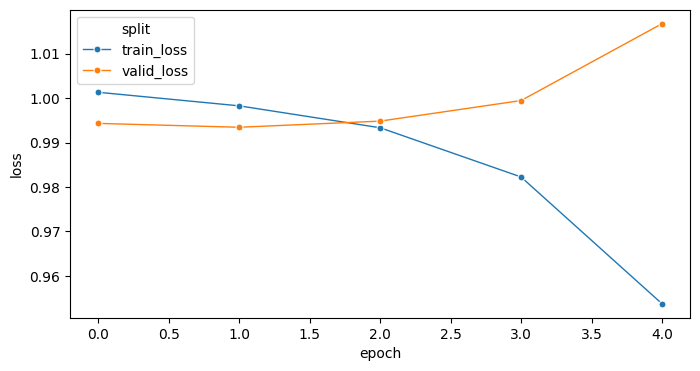

In [67]:
# Plot them
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(
    data=log_output_df,
    x="epoch",
    y="loss",
    hue="split",
    marker="o",
    markersize=5,
    linewidth=1,
    ax=ax,
);

Generally, we expect the training loss to steadily decrease from epoch to epoch, and the validation loss to initially decrease, and then eventually start increasing (i.e. the model enters the "overfitting" regime).

## 5. Evaluate test performance

As we did in part 1, we can also measure the performance of our model on a test set which was not seen during training (i.e. "held-out"). This gives us an estimate of the generalization performance of our model.

In [68]:
y_true = torch.concat([batch[1] for batch in test_dataloader], dim=0)
y_pred = torch.concat(trainer.predict(dataloaders=test_dataloader), dim=0)

assert y_pred.shape == y_true.shape

/private/home/hubertjb/miniconda3/envs/brainai_v2/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /private/home/hubertjb/miniconda3/envs/brainai_v2/li ...
/private/home/hubertjb/miniconda3/envs/brainai_v2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at results/logs/word_decoding/version_5/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at results/logs/w

Predicting: |          | 0/? [00:00<?, ?it/s]

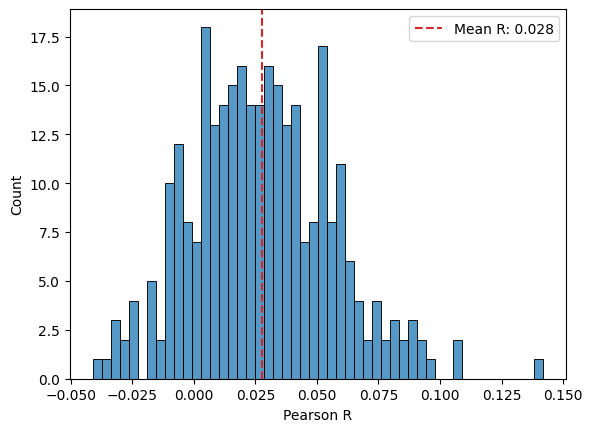

In [72]:
# Compute Pearson correlation
corr = pearsonr(y_true, y_pred, axis=0).statistic

ax = sns.histplot(corr, bins=50)
ax.axvline(
    corr.mean(),
    color="tab:red",
    linestyle="--",
    label=f"Mean R: {corr.mean():0.3f}",
)
ax.set_xlabel("Pearson R")
ax.legend()

[Add some kind of conclusion]

## 6. Putting everything together into an `Experiment` class

Finally, as we did in part 1, we can leverage `exca` to structure the entire pipeline into a single configurable class:

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger


class DeepDecodingExperiment(pydantic.BaseModel):
    data: Data

    # Splits
    valid_split_ratio: float = 0.1
    test_split_ratio: float = 0.1
    split_random_state: int | None = 42

    # Dataloaders
    batch_size: int = 128
    num_workers: int = 10

    # Model
    seed: int | None = None

    # Optimization
    loss_name: tp.Literal["mse", "clip"] = "mse"
    learning_rate: float = 3e-4
    weight_decay: float = 0.01
    n_epochs: int = 10
    patience: int = 3

    # exca
    infra: TaskInfra = TaskInfra()

    def _prepare_loaders(self, X: np.ndarray, y: np.ndarray) -> list[DataLoader]:
        """Prepare dataloaders."""

        # Split into train/valid/test
        X_train, X_test, y_train, y_test  = train_test_split(
            X,
            y,
            shuffle=False,
            test_size=self.test_split_ratio,
            # random_state=self.split_random_state,
        )
        X_train, X_valid, y_train, y_valid  = train_test_split(
            X_train,
            y_train,
            shuffle=True,
            test_size=self.valid_split_ratio / (1 - self.test_split_ratio),
            # random_state=self.split_random_state,
        )

        # Normalize targets
        target_scaler = StandardScaler()
        y_train = target_scaler.fit_transform(y_train)
        y_valid = target_scaler.transform(y_valid)
        y_test = target_scaler.transform(y_test)

        # Create datasets and dataloaders
        train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

        valid_dataset = TensorDataset(torch.tensor(X_valid).float(), torch.tensor(y_valid).float())
        valid_dataloader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        print("Number of examples in each split")
        print(f"Train:\t{len(train_dataset)}")
        print(f"Valid:\t{len(valid_dataset)}")
        print(f"Test:\t{len(test_dataset)}")

        return train_dataloader, valid_dataloader, test_dataloader

    def _prepare_model(self, in_channels: int, out_channels: int) -> SimpleConv:
        return SimpleConv(
            in_channels=in_channels,
            out_channels=out_channels,
            hidden=320,
            depth=4,
            kernel_size=3,
            growth=1.0,
        )

    def _prepare_trainer(self) -> pl.Trainer:
        callbacks = [
            EarlyStopping(
                monitor="valid_loss",
                min_delta=0.00,
                patience=self.patience,
                mode="min",
            ),
            ModelCheckpoint(
                filename="best",
                monitor="valid_loss",
                mode="min",
                save_top_k=1,
            ),
        ]

        logger = CSVLogger(self.infra.uid_folder() / "logs", name="word_decoding")

        return pl.Trainer(
            max_epochs=self.n_epochs,
            accelerator="auto",
            callbacks=callbacks,
            num_sanity_val_steps=0,  # Turn off sanity checking of validation dataloader
            logger=logger,
        )

    def _evaluate_corr(self, trainer: pl.Trainer, test_loader: DataLoader) -> np.ndarray:
        y_true = torch.concat([batch[1] for batch in test_loader], dim=0)
        y_pred = torch.concat(trainer.predict(dataloaders=test_loader), dim=0)
        return pearsonr(y_true, y_pred, axis=0).statistic

    @infra.apply
    def run(self) -> np.ndarray:
        """Fit and evaluate a deep decoding model."""

        print(f"Decoding {self.data.feature.feature} from {self.data.n_sessions} sessions")
        X, y = self.data()
        train_loader, valid_loader, test_loader = self._prepare_loaders(X, y)

        # Prepare model
        pl.seed_everything(self.seed)
        model = self._prepare_model(X.shape[1], y.shape[1])

        # Prepare pytorch lightning module
        loss_fn = nn.MSELoss() if self.loss_name == "mse" else ClipLoss()
        module = BrainModule(
            model=model,
            loss_fn=loss_fn,
            learning_rate=self.learning_rate,
            weight_decay=self.weight_decay,
        )

        # Prepare trainer
        trainer = self._prepare_trainer()

        print("Fitting model")
        trainer.fit(
            model=module,
            train_dataloaders=train_loader,
            val_dataloaders=valid_loader
        )

        # Predict and evaluate performance
        corr = self._evaluate_corr(trainer, test_loader)
        print(f"Test mean Pearson R: {corr.mean():0.3f}")

        return corr



# --- BONUS - For contrastive learning with CLIP loss ---

from torch.nn.functional import cross_entropy

class ClipLoss(nn.Module):
    """CLIP constrastive loss [1]_ with configuration from [2]_.

    References
    ----------
    .. [1] Radford, Alec, et al. "Learning transferable visual models from natural language
        supervision." International conference on machine learning. PMLR, 2021.
    .. [2] Défossez, Alexandre, et al. "Decoding speech perception from non-invasive brain
        recordings." Nature Machine Intelligence (2023): 1-11.
    """
    @staticmethod
    def _compute_similarity(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        inv_norms = 1 / (y.norm(dim=(1), p=2) + 1e-15)
        return torch.einsum("bc,oc,o->bo", x, y, inv_norms)

    # XXX Change to y_pred, y_true
    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """Warning: y_pred and y_true are not necessarily symmetrical.

        If y_pred of shape [B, C] and y_true of shape [B', C] with B'>=B, the first B samples
        of y_true are targets, while the remaining B'-B samples of y_true are only used as
        negatives.
        """
        scores = self._compute_similarity(y_pred, y_true)
        target = torch.arange(len(scores), device=y_pred.device)

        return cross_entropy(scores, target, reduction="mean")

Our entire experiment can now be configured using a dictionary (let's make a version that will run quickly to start with):

In [ ]:
exp_config = {
  "data": {
      "neuro": {
          "preproc_path": DATA_DIR,
          "tmin": -0.2,
          "tmax": 1.8 - 1/80,
          "apply_robust_scaler": True,
      },
      "feature": {
          "feature": "word_embedding",
          "infra": {
              "folder": CACHE_DIR,
          },
      },
      "n_sessions": 2,
  },
  # Splitting
  "valid_split_ratio": 0.1,
  "test_split_ratio": 0.1,
  "split_random_state": 42,
  # Dataloaders
  "batch_size": 128,
  "num_workers": 10,
  # Optimization
  "loss_name": "mse",
  "learning_rate": 3e-4,
  "weight_decay": 0.01,
  "n_epochs": 1,
  "patience": 1,
  # Exca
  "infra": {
      "folder": RESULTS_DIR,
  },
}

In [ ]:
exp = DeepDecodingExperiment(**exp_config)

# Uncomment to run the experiment (will take some time and memory):
# corr = exp.run()

Of note, using `exca`, we can easily launch multiple versions of our experiment in parallel with a [SLURM array](https://slurm.schedmd.com/job_array.html).

E.g., we could test the impact of different loss functions, batch sizes, learning rates and random seeds like this:

In [ ]:
from copy import deepcopy
from itertools import product
from tqdm import tqdm

loss_names = ["mse", "clip"]
batch_sizes = [32, 64, 128]
learning_rates = [3e-5, 3e-4, 3e-3]
seeds = [33, 34, 35]

task = DeepDecodingExperiment(**exp_config)
with task.infra.job_array() as tasks:
    for (
        loss_name,
        batch_size,
        learning_rate,
        seed
    ) in tqdm(list(product(
        loss_names,
        batch_sizes,
        learning_rates,
        seeds,
    )), "Preparing tasks"):
        updated_config = deepcopy(exp_config)
        updated_config["loss_name"] = loss
        updated_config["batch_size"] = batch_size
        updated_config["learning_rate"] = learning_rate
        updated_config["seed"] = seed

        task_ = DeepDecodingExperiment(**updated_config)

        # Uncomment this line on a SLURM cluster to launch all jobs as a SLURM array:
        # tasks.append(task_)

## Going further

This is it for part 3 of this tutorial! 🎉

🔧 To improve the *flexibility of our pipeline*, next steps may include:
- Further expose components as configurable Pydantic objects (e.g. deep learning architecture, loss functions, etc.)
- Monitor performance metrics during training using [TorchMetrics](https://lightning.ai/docs/torchmetrics/)
- Log results to a live visualization platform, e.g. [Weights & Biases](https://wandb.ai/) or [Tensorboard](https://www.tensorflow.org/tensorboard)

📈 To improve *performance*, next steps may include:
- Including more recordings into our training dataset
- Improving the architecture (deeper/wider, handling channel positions, word-level modelling, etc.)
- Optimizing the hyperparameters (learning rate, batch size, etc.).

Have fun!